In [283]:
import pandas as pd
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt

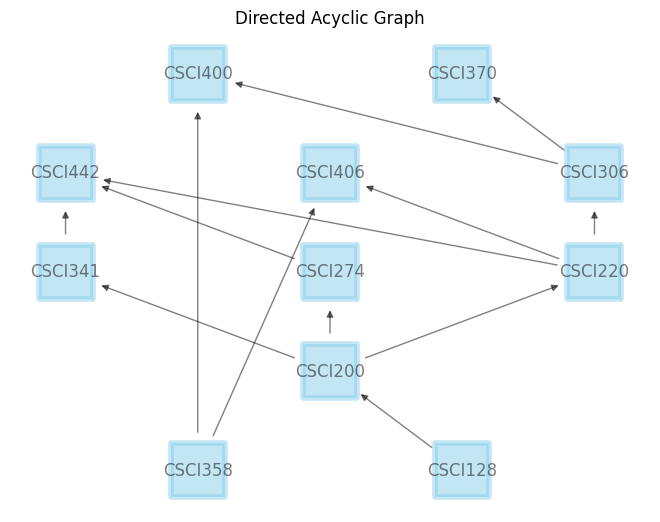

In [284]:
# create dag
reader = pd.read_csv('../data/dag_simple.csv')
dag = nx.DiGraph()

for i in range(len(reader)):
    dag.add_edge(reader['prereq'][i], reader['class'][i])

for layer, nodes in enumerate(nx.topological_generations(dag)):
    for node in nodes:
        dag.nodes[node]["layer"] = layer

# plot the dag
pos = nx.multipartite_layout(dag,subset_key="layer", align='horizontal')
nx.draw(dag, pos, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.5, linewidths=4)
plt.title('Directed Acyclic Graph')
plt.show()

# Eligible

In [306]:
taken_df = pd.read_csv('../data/CS_Course_Enrollment_Data_Pivot.csv')

# replace CSCI101 with CSCI128
taken_df['Class'] = taken_df['Class'].replace('CSCI101', 'CSCI128')

# add numerical conversion 
UNIQUE_SEM = 4
taken_df['Taken_Num'] = np.select([
    taken_df['Taken_Semester'] == 'Spring',
    taken_df['Taken_Semester'] == 'Summer One',
    taken_df['Taken_Semester'] == 'Summer Two',
    taken_df['Taken_Semester'] == 'Fall'
    ], 
    [taken_df['Taken_Year'] * UNIQUE_SEM, 
    taken_df['Taken_Year'] * UNIQUE_SEM + 1, 
    taken_df['Taken_Year'] * UNIQUE_SEM + 2,
    taken_df['Taken_Year'] * UNIQUE_SEM + 3], 
    default = 'UNKNOWN')

taken_df['Admitted_Num'] = np.select([
    taken_df['Admitted_Semester'] == 'Spring',
    taken_df['Admitted_Semester'] == 'Summer One',
    taken_df['Admitted_Semester'] == 'Summer Two',
    taken_df['Admitted_Semester'] == 'Summer',
    taken_df['Admitted_Semester'] == 'Fall'
    ], 
    [taken_df['Admitted_Year'] * UNIQUE_SEM, 
    taken_df['Admitted_Year'] * UNIQUE_SEM + 1, 
    taken_df['Admitted_Year'] * UNIQUE_SEM + 2,
    taken_df['Admitted_Year'] * UNIQUE_SEM + 1,
    taken_df['Admitted_Year'] * UNIQUE_SEM + 3], 
    default = 'UNKNOWN')

taken_df['Taken_Num'] = taken_df['Taken_Num'].astype(int)

In [307]:
taken_df[taken_df['Taken_Num'] == 'UNKNOWN']
taken_df[taken_df['Admitted_Num'] == 'UNKNOWN']

,Semester Admitted,Department,Major,id,Taken,Class,Type,Taken_Semester,Taken_Year,Admitted_Semester,Admitted_Year,Taken_Num,Admitted_Num


In [308]:
# find in-degrees of dag
in_degrees = dict(dag.in_degree())
in_degrees = dict(sorted(in_degrees.items()))
print(in_degrees)

{'CSCI128': 0, 'CSCI200': 1, 'CSCI220': 1, 'CSCI274': 1, 'CSCI306': 1, 'CSCI341': 1, 'CSCI358': 0, 'CSCI370': 1, 'CSCI400': 2, 'CSCI406': 2, 'CSCI442': 3}


In [309]:
# create carry-through df
carry_through = pd.DataFrame(columns=['Semester_Num'] + list(in_degrees.keys()))

# find uniques
unique_ids = taken_df['id'].unique()
unique_nums = sorted(taken_df['Taken_Num'].unique())
unique_nums += [int(max(unique_nums)) + 1]

for num in unique_nums: 
    temp = [num] + list(in_degrees.values())
    carry_through = pd.concat([carry_through, pd.DataFrame([temp], columns=carry_through.columns)], ignore_index=True)

carry_through = carry_through.astype({'Semester_Num': 'int32'})
carry_through

,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442
0,8068,0,1,1,1,1,1,0,1,2,2,3
1,8069,0,1,1,1,1,1,0,1,2,2,3
2,8070,0,1,1,1,1,1,0,1,2,2,3
3,8071,0,1,1,1,1,1,0,1,2,2,3
4,8072,0,1,1,1,1,1,0,1,2,2,3
5,8073,0,1,1,1,1,1,0,1,2,2,3
6,8074,0,1,1,1,1,1,0,1,2,2,3
7,8075,0,1,1,1,1,1,0,1,2,2,3
8,8076,0,1,1,1,1,1,0,1,2,2,3
9,8079,0,1,1,1,1,1,0,1,2,2,3


In [310]:
def out_calc(G,cl):
    if G.has_node(cl):
        return list(G.successors(cl))
    else:
        return []

In [311]:
cols = ['id'] + list(carry_through.columns)
carry_out = pd.DataFrame(columns=cols)

In [312]:
admit_df = taken_df[['id', 'Admitted_Num']].drop_duplicates()

In [313]:
for i in unique_ids: 

    # find admit_num for id
    admit_num = admit_df[admit_df['id'] == i]['Admitted_Num'].values[0]

    # create copy and assign 
    temp_df = carry_through.copy()
    temp_df['id'] = i
    temp_df = temp_df[temp_df['Semester_Num'] >= int(admit_num)]

    # find taken records from taken_df
    taken_temp = taken_df[taken_df['id'] == i]
    taken_temp = taken_temp.sort_values(by='Taken_Num')

    # iterate through taken records
    for index, row in taken_temp.iterrows():
        # affect classes
        affected_classes = out_calc(dag, row['Class']) + [row['Class']] # find classes
        for cl in affected_classes:
             # decrement out-degrees for all semesters after the current semester
            temp_df.loc[temp_df['Semester_Num'] > row['Taken_Num'], cl] -= 1
    
    carry_out = pd.concat([carry_out, temp_df], ignore_index=True)

carry_out

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442
0,134,8071,0,1,1,1,1,1,0,1,2,2,3
1,134,8072,-1,-1,0,0,1,0,0,1,2,2,3
2,134,8073,-1,-1,0,0,1,0,0,1,2,2,3
3,134,8074,-1,-1,0,0,1,0,0,1,2,2,3
4,134,8075,-1,-1,0,0,1,0,0,1,2,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
39672,7157,8088,0,1,1,1,1,1,0,1,2,2,2
39673,7157,8091,0,1,1,1,1,1,0,1,2,2,2
39674,7157,8092,0,1,1,1,1,1,0,1,2,2,2
39675,7157,8095,0,1,1,1,1,1,0,1,2,2,2


In [314]:
# convert Semseter_Num as int back into year and semester
carry_out = carry_out.astype({'Semester_Num': 'int32'})
carry_out['Year'] = carry_out['Semester_Num'] // UNIQUE_SEM
carry_out['Semester'] = carry_out['Semester_Num'] % UNIQUE_SEM

carry_out['Semester'] = np.select([
    carry_out['Semester'] == 0,
    carry_out['Semester'] == 1,
    carry_out['Semester'] == 2,
    carry_out['Semester'] == 3
    ], 
    ['Spring', 'Summer One', 'Summer Two', 'Fall'], 
    default = 'UNKNOWN')

# clean and concat
carry_out['Year_Semester'] = carry_out['Semester'].astype(str) + ' ' + carry_out['Year'].astype(str)
carry_out = carry_out.drop(columns=['Year', 'Semester'])
carry_out

,id,Semester_Num,CSCI128,CSCI200,CSCI220,CSCI274,CSCI306,CSCI341,CSCI358,CSCI370,CSCI400,CSCI406,CSCI442,Year_Semester
0,134,8071,0,1,1,1,1,1,0,1,2,2,3,Fall 2017
1,134,8072,-1,-1,0,0,1,0,0,1,2,2,3,Spring 2018
2,134,8073,-1,-1,0,0,1,0,0,1,2,2,3,Summer One 2018
3,134,8074,-1,-1,0,0,1,0,0,1,2,2,3,Summer Two 2018
4,134,8075,-1,-1,0,0,1,0,0,1,2,2,3,Fall 2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39672,7157,8088,0,1,1,1,1,1,0,1,2,2,2,Spring 2022
39673,7157,8091,0,1,1,1,1,1,0,1,2,2,2,Fall 2022
39674,7157,8092,0,1,1,1,1,1,0,1,2,2,2,Spring 2023
39675,7157,8095,0,1,1,1,1,1,0,1,2,2,2,Fall 2023


# Plots and Whatnots

/var/folders/kj/d1xg4wx91kd1nwc9s2xdpz_r0000gn/T/ipykernel_56764/2282939103.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_taken['Year_Semester'] = temp_taken['Taken_Semester'] + ' ' + temp_taken['Taken_Year'].astype(str)


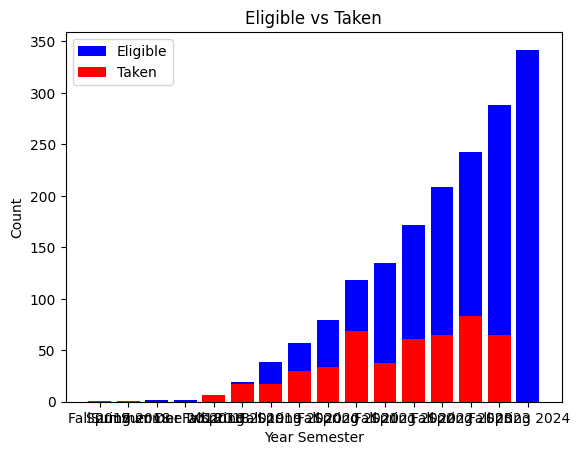

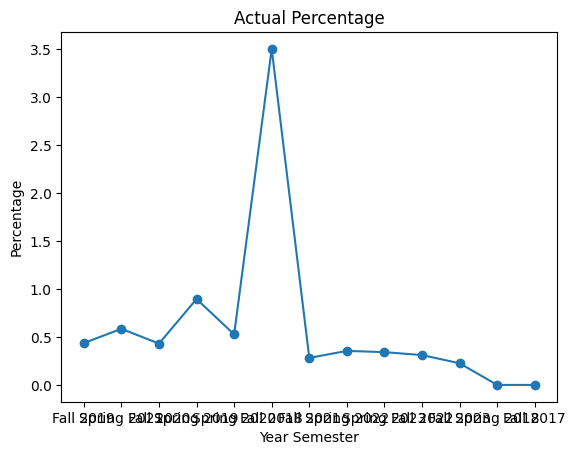

In [317]:
def plot_eligible_to_taken(carry_out, cl):

    # initialize 
    temp_carry = carry_out[['Year_Semester', cl]]
    temp_taken = taken_df[taken_df['Class'] == cl]
    temp_taken['Year_Semester'] = temp_taken['Taken_Semester'] + ' ' + temp_taken['Taken_Year'].astype(str)
    eligible_dict = { sem:0 for sem in temp_carry['Year_Semester'].unique() }
    taken_dict = { sem:len(temp_taken[temp_taken['Year_Semester'] == sem]) for sem in temp_carry['Year_Semester'].unique() }
    
    # find eligible
    for ys in eligible_dict.keys():
        eligible_dict[ys] = len(temp_carry[(temp_carry['Year_Semester'] == ys) & (temp_carry[cl] == 0)])
    
    actual_dict = {sem:0 for sem in temp_taken['Year_Semester'].unique()}
    
    for sem in temp_taken['Year_Semester'].unique(): 
        if eligible_dict[sem] != 0:
            actual_dict[sem] = taken_dict[sem] / eligible_dict[sem]
        else:
            actual_dict[sem] = 0
        

    # plot hist
    plt.bar(eligible_dict.keys(), eligible_dict.values(), color='b', label='Eligible')
    plt.bar(taken_dict.keys(), taken_dict.values(), color='r', label='Taken')
    plt.xlabel('Year Semester')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.title('Eligible vs Taken')
    plt.legend()
    plt.show()

    # plot line graph of actual
    plt.plot(actual_dict.keys(), actual_dict.values(), marker='o')
    plt.xlabel('Year Semester')
    plt.ylabel('Percentage')
    # plt.ylim(0, 1.1)
    plt.xticks(rotation=45)
    plt.title('Actual Percentage')
    plt.show()

plot_eligible_to_taken(carry_out, 'CSCI442')

Fall 2017
Spring 2018
Fall 2018
Spring 2019
